In [1]:
%cd ../tfa

/home/work/AnacondaProjects/HTFATorch/tfa


In [2]:
# import dependencies
import logging
import tfa as TFA
import utils

/home/work/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


02/13/2018 11:09:38 [Epoch 1] (988ms) Posterior free-energy 1.68533594e+09
02/13/2018 11:09:39 [Epoch 2] (1028ms) Posterior free-energy 5.68535936e+08
02/13/2018 11:09:40 [Epoch 3] (994ms) Posterior free-energy 3.79256448e+08
02/13/2018 11:09:41 [Epoch 4] (1000ms) Posterior free-energy 3.75218816e+08
02/13/2018 11:09:42 [Epoch 5] (987ms) Posterior free-energy 3.71167424e+08
02/13/2018 11:09:43 [Epoch 6] (1057ms) Posterior free-energy 3.53737024e+08
02/13/2018 11:09:44 [Epoch 7] (1192ms) Posterior free-energy 3.26680512e+08
02/13/2018 11:09:45 [Epoch 8] (1189ms) Posterior free-energy 3.04831712e+08
02/13/2018 11:09:46 [Epoch 9] (1049ms) Posterior free-energy 2.88212128e+08
02/13/2018 11:09:48 [Epoch 10] (1433ms) Posterior free-energy 2.78998656e+08
02/13/2018 11:09:50 [Epoch 11] (2033ms) Posterior free-energy 2.73397440e+08
02/13/2018 11:09:52 [Epoch 12] (2392ms) Posterior free-energy 2.69740160e+08
02/13/2018 11:09:55 [Epoch 13] (2461ms) Posterior free-energy 2.66979104e+08
02/13/2018 

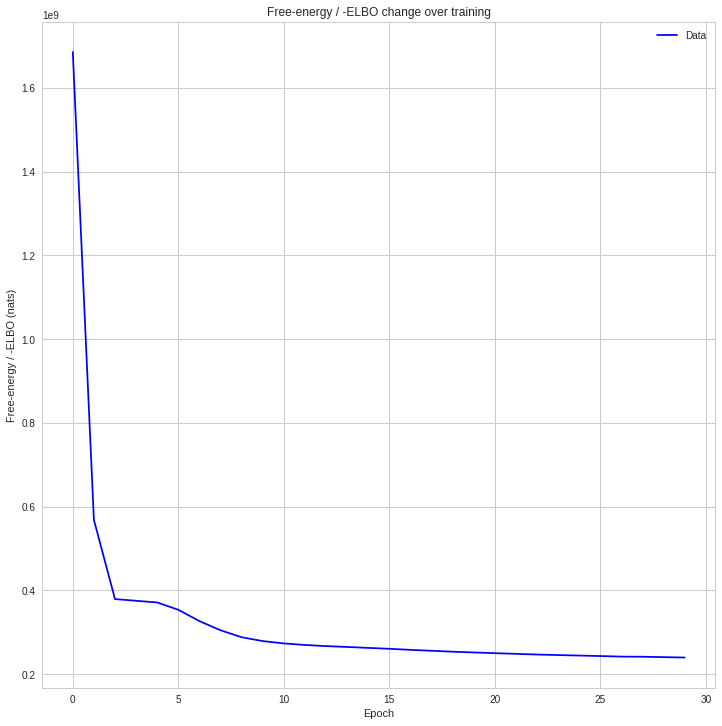

02/13/2018 11:10:29 Mean Factor Centers: [[  8.832828  -52.12596    18.433788 ]
 [ -5.068115  -55.227173   51.338093 ]
 [  3.343951  -56.458553   39.438343 ]
 [-10.340782  -46.64087    34.011192 ]
 [  3.815696  -41.506668   29.387201 ]
 [  5.2445145 -46.493744   50.67914  ]
 [  9.139461  -59.298996   29.59811  ]
 [ -7.8923416 -63.9932     27.167435 ]
 [ -0.8216025 -50.886913   21.323296 ]
 [  5.926461  -70.078384   46.45415  ]]
02/13/2018 11:10:29 Mean Factor Log Widths: [5.463699  5.5695624 5.2627716 4.457105  5.2301087 5.112689  5.3204436
 5.3765287 4.661654  5.503806 ]
02/13/2018 11:10:29 Mean Weights: [[-0.07587457  3.824186   -4.2442636  ...  2.32018     0.40458563
   3.5836222 ]
 [-0.71830493  2.8050785  -1.068423   ...  1.5175992   0.0926231
   1.5395733 ]
 [-1.2842177   1.3144096  -0.517395   ...  0.40108126 -0.9686322
   0.31223482]
 ...
 [-0.87255913  0.38784385 -1.9220253  ... -0.12947218 -0.03594877
   0.2859159 ]
 [-0.904952    0.45146966 -2.305832   ...  0.0292709   0.112

In [9]:
tfa = TFA.TopographicalFactorAnalysis('/home/work/AnacondaProjects/HTFATorch/data/s0.mat', num_factors=10)
losses = tfa.train(num_steps=15, log_level=logging.INFO)

utils.plot_losses(losses)

means = tfa.mean_parameters(log_level=logging.INFO)

results = tfa.results()
logging.info(results)

In [10]:
import hypertools as hyp
import numpy as np
import seaborn as sns

import nilearn.plotting as niplot

from nilearn.input_data import NiftiMasker
import nibabel as nib
import scipy.spatial.distance as sd

from IPython.display import YouTubeVideo, HTML

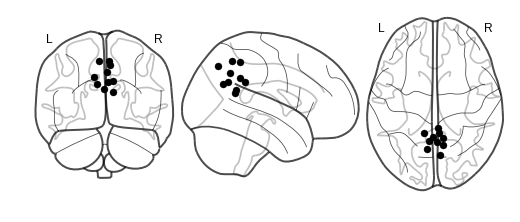

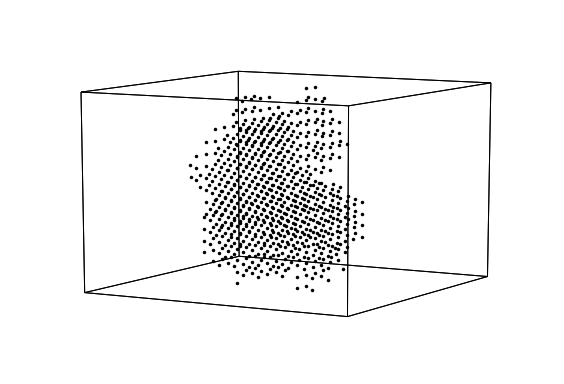

In [11]:
niplot.plot_connectome(np.eye(tfa.num_factors), means['mean_factor_center'], node_color='k')
hyp.plot(tfa.voxel_locations.numpy(), 'k.')